In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torcheval.metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score, mean_squared_error
import import_ipynb
import data_preprocessing  # Replace with the name of the notebook without `.ipynb`

['injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'injector_sum']
['tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph0

In [3]:
import pickleshare

In [6]:
%store -r u5_train_equil_pump
print(u5_train_equil_pump)

None


In [ ]:
# training data
# u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
# u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
# u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
# u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
# u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
# u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
# u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
# u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
# u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
# u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
# u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
# u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
# u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
# u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
# u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
# u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
# u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [21]:
u5_s01_equil_pump['injector_sum'].max()


np.float64(117.35216456225271)

In [3]:
u5_control_vars = data_preprocessing.u5_control_vars
print(u5_control_vars)
natural_control_vars = ['canal_level', 'canal_tmp', 'lake_tmp', 'water_primary_cold_tmp']
features = [
    'tot_activepower', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening',
    'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow',
    'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed',
    'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'timer_turbine_on_off', 
    'ext_tmp', 'plant_tmp',
    'minute', 'hour', 'day', 'month', 'year', 'dayofweek','dayofyear', 'is_weekend'
]

['tot_activepower' 'charge' 'coupler_position' 'injector_01_opening'
 'injector_02_opening' 'injector_03_opening' 'injector_04_opening'
 'injector_05_opening' 'pump_calculated_flow' 'pump_pressure_diff'
 'pump_rotspeed' 'turbine_pressure' 'turbine_rotspeed'
 'water_primary_pump_01_opening' 'water_primary_pump_02_opening'
 'timer_turbine_on_off' 'timer_injector_opening' 'ext_tmp' 'plant_tmp']


In [4]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in u5_train_equil_pump.columns]

target = 'injector_sum'

# Split the data into training and testing sets
X = u5_train_equil_pump[features]
y = u5_train_equil_pump[target]

In [5]:
class RegressiveNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressiveNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X.shape[1]
model = RegressiveNN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

epochs = 50
batch_size = 32
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.3383
Epoch 20/50, Loss: 0.0878
Epoch 30/50, Loss: 0.0607
Epoch 40/50, Loss: 0.0466
Epoch 50/50, Loss: 0.0354


In [7]:
# Switch the model to evaluation mode
model.eval()

# Predict using the test data
with torch.no_grad():
    reconstructed = model(X_tensor)  # Predictions from the model

# Convert tensors back to numpy for plotting
reconstructed = reconstructed.numpy()
original = y
r2_score(original, reconstructed)

0.992887273336561

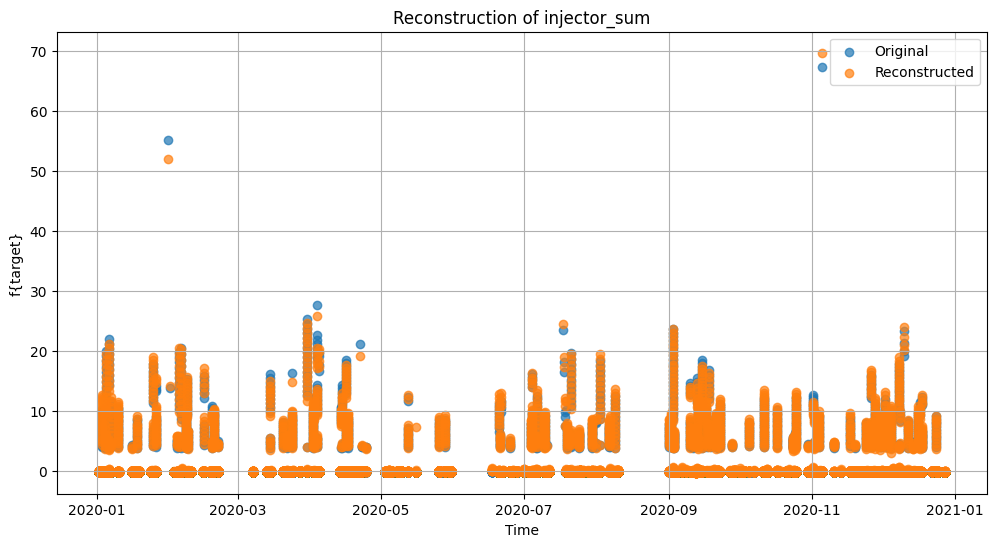

In [8]:
# Convert tensors back to numpy for plotting
time_index = X.index

reconstructed = reconstructed.flatten()  # Ensure predictions are 1D
# original = original.flatten()  # Ensure targets are 1D

# Plot original vs reconstructed with time as the x-axis
plt.figure(figsize=(12, 6))
plt.scatter(time_index, original, label="Original", linewidth=1, alpha=0.7)
plt.scatter(time_index, reconstructed, label="Reconstructed", alpha=0.7)
plt.title(f'Reconstruction of {target}')
plt.xlabel('Time')
plt.ylabel('f{target}')
plt.legend()
plt.grid(True)
plt.show()


#### Prediction on synethetic dataset

In [16]:
u5_s01_equil_pump['injector_sum'].value_counts()

injector_sum
-0.012595      22194
 21.395035         1
 19.156570         1
 117.352165        1
 50.717676         1
 70.900950         1
Name: count, dtype: int64

In [10]:
# Extracting the features and target from the synthetic test set
X_synthetic = u5_s01_equil_pump[features]
X_synthetic = torch.tensor(X_synthetic.values, dtype=torch.float32)

y_synthetic = u5_s01_equil_pump[target]
y_synthetic = torch.tensor(y_synthetic.values, dtype=torch.float32).view(-1, 1)


# Predict using the trained model
y_pred_synthetic = model(X_synthetic)

In [11]:
r2_metric = torcheval.metrics.R2Score()

In [12]:
# Evaluate the model performance on synthetic data

mse_synthetic = criterion(y_pred_synthetic, y_synthetic)
r_squared_synthetic = r2_metric.update(y_synthetic, y_pred_synthetic).compute()

print(f'Mean Squared Error on Synthetic Data: {mse_synthetic}')
# print(f'Root Mean Squared Error on Synthetic Data: {rmse_synthetic}')
print(f"R squared : {r_squared_synthetic}")

Mean Squared Error on Synthetic Data: 0.4153737425804138
R squared : 0.26304978132247925


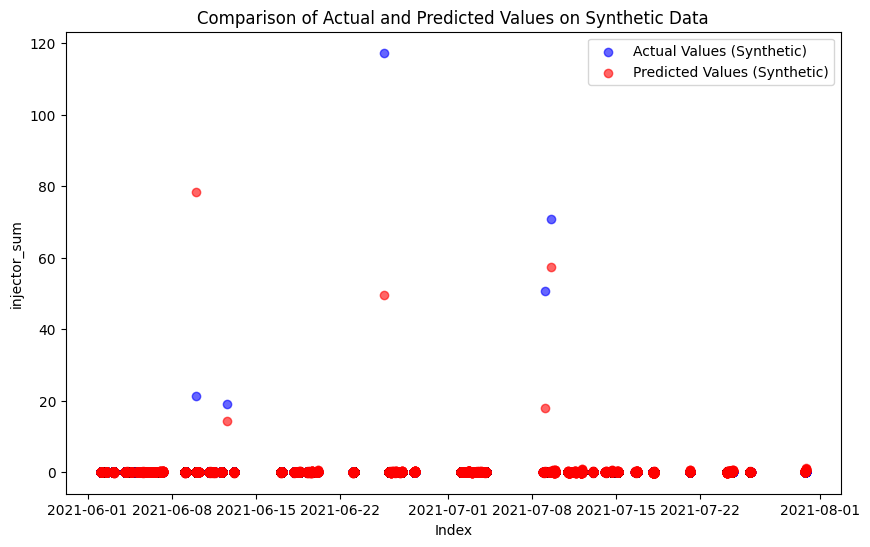

In [15]:
# Visualizing the results with a scatter plot for actual vs predicted values
# Convert predictions to a NumPy array for plotting
y_pred_synthetic_np = y_pred_synthetic.detach().numpy()
y_synthetic_np = y_synthetic.numpy()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(u5_s01_equil_pump.index, y_synthetic_np, label='Actual Values (Synthetic)', color='blue', alpha=0.6)
plt.scatter(u5_s01_equil_pump.index, y_pred_synthetic_np, label='Predicted Values (Synthetic)', color='red', alpha=0.6)
plt.title('Comparison of Actual and Predicted Values on Synthetic Data')
plt.xlabel('Index')
plt.ylabel(f'{target}')
plt.legend()
plt.show()

In [14]:
u5_s01_equil_pump['anomaly'].value_counts()

anomaly
1    20079
0     2120
Name: count, dtype: int64